# Movie Recommender Systems: A Practical Tutorial

## What are Recommendation Systems?

Recommendation systems help us discover content we might like based on our past preferences. They're the technology behind "You might also like..." suggestions on sites like Netflix, Amazon, and Spotify.

There are two main approaches we'll explore in this notebook:

1. **User-Based Collaborative Filtering**: This is like asking your friends for movie recommendations. If you and another person have similar taste in movies you've both seen, you'll probably like the movies they enjoyed that you haven't watched yet.

2. **Matrix Factorization (SVD)**: This technique finds hidden patterns in people's preferences. For example, you might not explicitly state you like "sci-fi movies with strong hero leads" or "slow-paced character dramas," but the algorithm can discover these patterns in your ratings and recommend similar content.

## 1. Environment Setup

In [18]:
# Install required packages
# Only run this cell if you're in Google Colab to reproduce this notebook or need to install these packages
# !pip install numpy pandas scikit-learn scikit-surprise matplotlib seaborn

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
import surprise
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set styles for visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

## 2. Download and Load the MovieLens 100K Dataset

In [3]:
# Download the dataset if it doesn't exist
import os

if not os.path.exists('ml-100k'):
    import urllib.request
    import zipfile
    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    print(f"Downloading MovieLens 100K dataset from {url}")
    filename, _ = urllib.request.urlretrieve(url, 'ml-100k.zip')
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded and extracted.")
else:
    print("MovieLens 100K dataset already exists.")

Dataset downloaded and extracted.


In [4]:
# Load the ratings data
ratings_path = 'ml-100k/u.data'
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path, sep='\t', names=columns)

# Load movie information
movies_path = 'ml-100k/u.item'
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 
                 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 
                 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                 'Thriller', 'War', 'Western']
movies = pd.read_csv(movies_path, sep='|', names=movie_columns, encoding='latin-1')

# Remove the timestamp from ratings as we won't be using it
ratings = ratings.drop('timestamp', axis=1)

# Display the first few rows of each dataset
print("Ratings dataset:")
display(ratings.head())

print("\nMovies dataset:")
display(movies[['movie_id', 'title']].head())

Ratings dataset:


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1



Movies dataset:


,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


## Understanding the MovieLens Dataset

We'll use the MovieLens 100K dataset, which contains 100,000 ratings from 943 users on 1,682 movies. The MovieLens dataset contains movie ratings from real users. Each rating is on a scale of 1-5 stars. We'll use this data to:

1. See what movies people tend to rate highest.
2. Look at how many movies each user typically rates.
3. Understand which movies are most popular.
4. Train our recommendation algorithms to predict what rating a user would give to a movie they haven't seen yet.

This is similar to how Netflix learns your preferences from movies you've rated to recommend new movies you might enjoy.

## 3. Exploratory Data Analysis

Total number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682
Rating range: 1 to 5


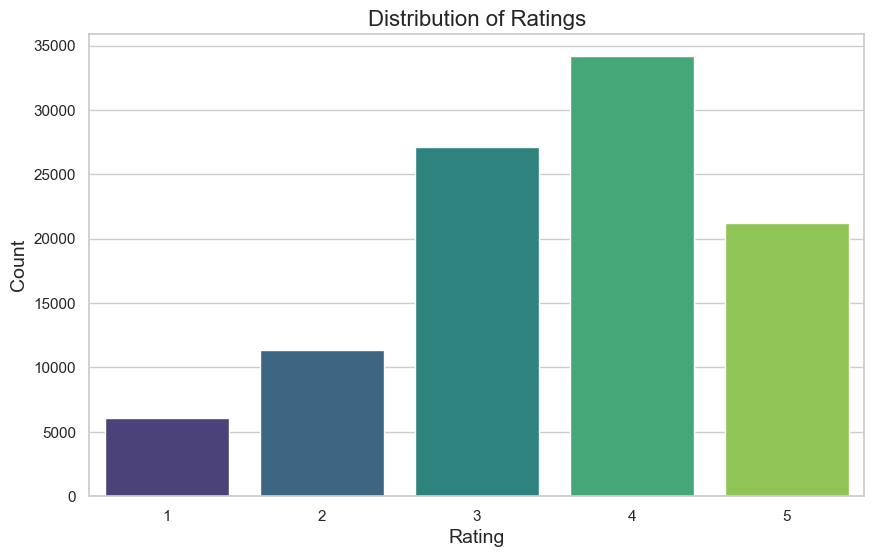

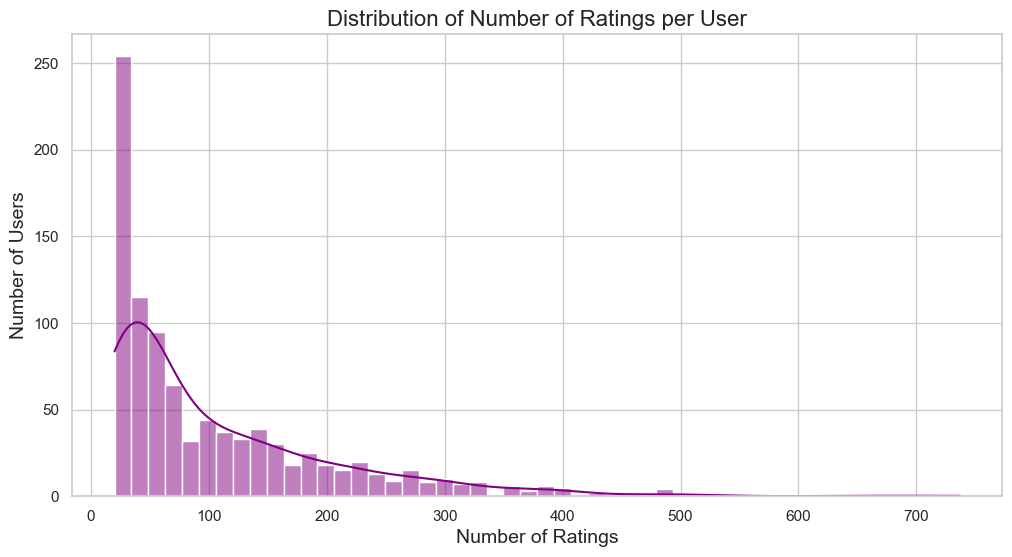

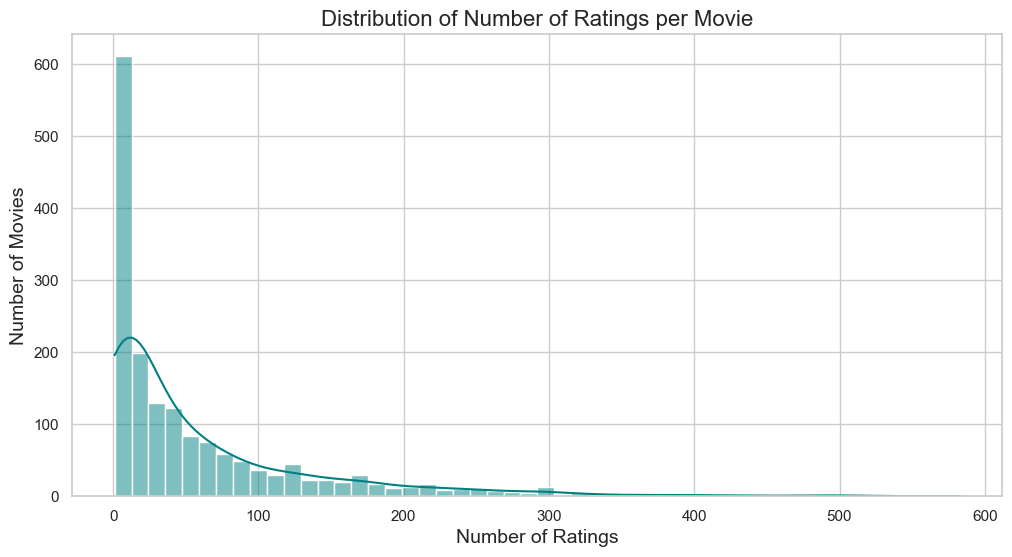

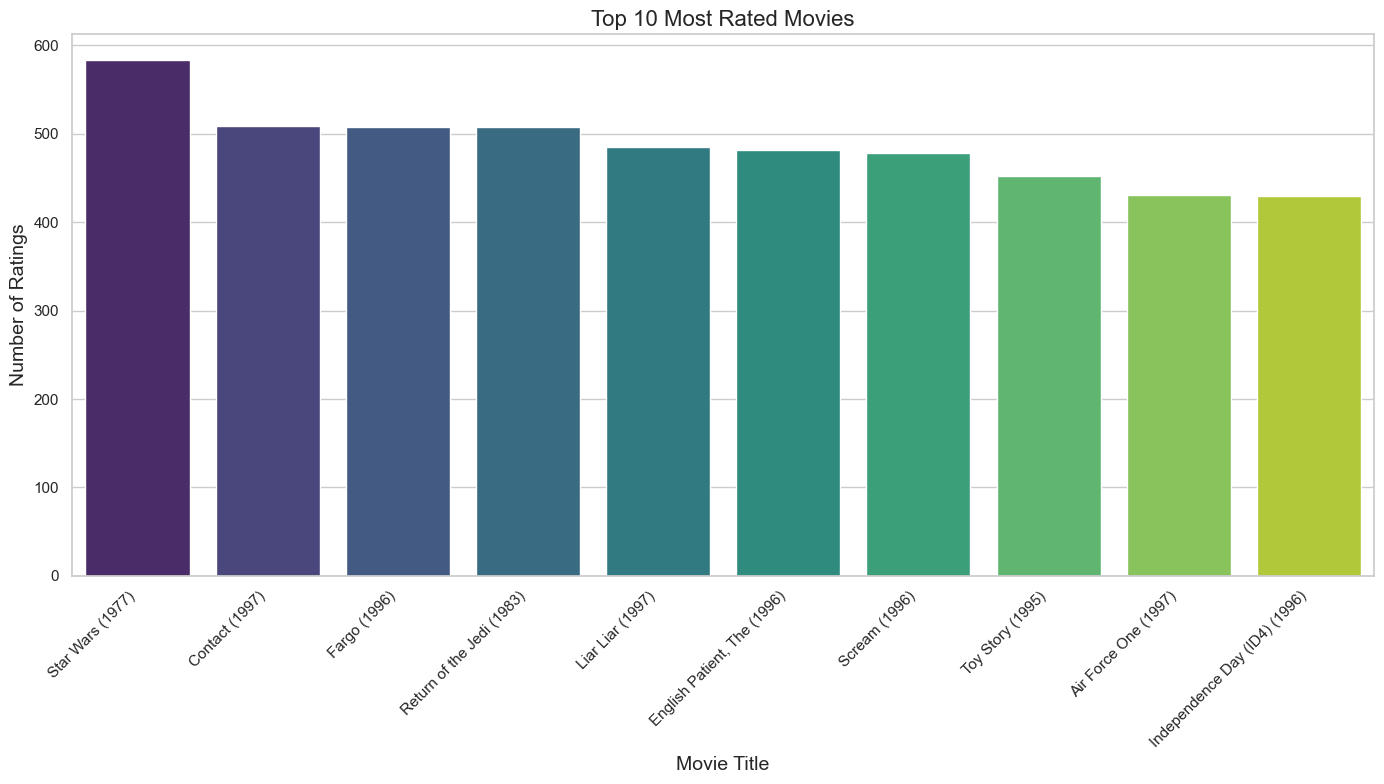

In [5]:
# Basic statistics of the dataset
print(f"Total number of ratings: {len(ratings)}")
print(f"Number of unique users: {ratings['user_id'].nunique()}")
print(f"Number of unique movies: {ratings['movie_id'].nunique()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()}")

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Number of ratings per user
user_ratings_count = ratings.groupby('user_id')['rating'].count().reset_index()
user_ratings_count.columns = ['user_id', 'count']

plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count['count'], bins=50, kde=True, color='purple')
plt.title('Distribution of Number of Ratings per User', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.show()

# Number of ratings per movie
movie_ratings_count = ratings.groupby('movie_id')['rating'].count().reset_index()
movie_ratings_count.columns = ['movie_id', 'count']

plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings_count['count'], bins=50, kde=True, color='teal')
plt.title('Distribution of Number of Ratings per Movie', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.show()

# Top 10 most rated movies
top_movies = movie_ratings_count.sort_values('count', ascending=False).head(10)
top_movies = top_movies.merge(movies[['movie_id', 'title']], on='movie_id')

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='title', y='count', data=top_movies, palette='viridis')
plt.title('Top 10 Most Rated Movies', fontsize=16)
plt.xlabel('Movie Title', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Create Training and Testing Sets

In [6]:
# Split the data for sklearn-based approaches
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 80000
Test set size: 20000


In [7]:
# Create user-item matrices with proper handling of NaN values
# For User-Based Collaborative Filtering

# Create a utility matrix (user-item matrix) for the training set
user_item_matrix_train = train_data.pivot(index='user_id', columns='movie_id', values='rating')

# Fill NaN values with 0 (representing no rating)
user_item_matrix_train_filled = user_item_matrix_train.fillna(0)

# Quick preview of the user-item matrix
print("User-Item Matrix Shape (users x movies):", user_item_matrix_train.shape)
display(user_item_matrix_train.iloc[:5, :5])  # Show a small part of the matrix

User-Item Matrix Shape (users x movies): (943, 1653)


movie_id,1,2,3,4,5
user_id,,,,,
1,NaN,3.0,4.0,NaN,3.0
2,4.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN


In [8]:
# For Surprise library (SVD)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

## 5. Model 1: User-Based Collaborative Filtering

### User-Based Collaborative Filtering Explained

User-based collaborative filtering works like this:

1. **Find Similar Users**: For a target user (let's call them Alex), we find other users who have similar taste in movies. We do this by comparing their ratings on movies both people have watched.

2. **Recommend What Similar Users Liked**: We then recommend movies that these similar users enjoyed but Alex hasn't watched yet.

For example, if Alex and Jordan both gave high ratings to "Star Wars" and "The Matrix" but low ratings to romantic comedies, they probably have similar taste. If Jordan loved "Blade Runner" (which Alex hasn't seen), it's likely that Alex would enjoy it too.

The "k" parameter represents how many similar users we consider when making recommendations. A higher k means we look at more users' opinions, which generally gives more reliable predictions (as we can see in the graph below).

In [9]:
# We'll implement a User-Based Collaborative Filtering approach
# 1. Find similar users
# 2. Generate recommendations based on what similar users liked

def user_based_cf(user_id, matrix, k_neighbors=10, n_recommendations=5):
    """
    Generate recommendations for a user using user-based collaborative filtering
    
    Parameters:
    - user_id: ID of the target user
    - matrix: User-item matrix where rows are users, columns are movies, and values are ratings
    - k_neighbors: Number of similar users to consider
    - n_recommendations: Number of movie recommendations to return
    
    Returns:
    - List of recommended movie IDs
    """
    # Get the user's row from the matrix
    if user_id not in matrix.index:
        raise ValueError(f"User ID {user_id} not found in the matrix.")
    
    user_row = matrix.loc[user_id].values.reshape(1, -1)
    
    # Fit the KNN model on the matrix
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k_neighbors+1)
    model_knn.fit(matrix.values)
    
    # Find the k nearest neighbors
    distances, indices = model_knn.kneighbors(user_row, n_neighbors=k_neighbors+1)
    
    # The first neighbor is the user itself, so we'll skip it
    similar_user_indices = indices.flatten()[1:]
    similar_users = matrix.index[similar_user_indices]
    
    # Get movies the user hasn't rated
    user_rated_movies = set(matrix.columns[matrix.loc[user_id] > 0])
    all_movies = set(matrix.columns)
    movies_to_recommend = all_movies - user_rated_movies
    
    # Calculate recommendation scores for each unseen movie
    movie_scores = []
    for movie_id in movies_to_recommend:
        # Get the ratings of similar users for this movie
        movie_ratings = matrix.loc[similar_users, movie_id]
        # Filter out users who haven't rated this movie
        valid_ratings = movie_ratings[movie_ratings > 0]
        
        if len(valid_ratings) > 0:
            # Calculate the weighted average rating
            # (Here, we're using a simple average, but you could use weighted average based on similarity)
            avg_rating = valid_ratings.mean()
            movie_scores.append((movie_id, avg_rating))
    
    # Sort by score and get the top n recommendations
    movie_scores.sort(key=lambda x: x[1], reverse=True)
    recommended_movies = [movie_id for movie_id, score in movie_scores[:n_recommendations]]
    
    return recommended_movies, movie_scores[:n_recommendations]

In [10]:
# Evaluate the User-Based CF model using RMSE
def evaluate_user_based_cf(train_matrix, test_data, k_neighbors=10):
    # Create a copy to avoid modifying the original
    train_matrix_copy = train_matrix.copy()
    
    # Initialize KNN model
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k_neighbors+1)
    model_knn.fit(train_matrix_copy.values)
    
    predictions = []
    actual_ratings = []
    
    # Use a sample of test data to speed up evaluation
    sample_size = min(10000, len(test_data))
    test_sample = test_data.sample(n=sample_size, random_state=42)
    
    for _, row in test_sample.iterrows():
        user_id = row['user_id']
        movie_id = row['movie_id']
        actual_rating = row['rating']
        
        # Skip if user or movie is not in the training set
        if user_id not in train_matrix_copy.index:
            continue
        if movie_id not in train_matrix_copy.columns:
            continue
        
        # Get the user's row
        user_row = train_matrix_copy.loc[user_id].values.reshape(1, -1)
        
        # Find similar users
        distances, indices = model_knn.kneighbors(user_row, n_neighbors=k_neighbors+1)
        similar_user_indices = indices.flatten()[1:]  # Skip the user itself
        similar_users = train_matrix_copy.index[similar_user_indices]
        
        # Get ratings for the movie from similar users
        similar_users_ratings = train_matrix_copy.loc[similar_users, movie_id]
        valid_ratings = similar_users_ratings[similar_users_ratings > 0]
        
        if len(valid_ratings) > 0:
            # Predict rating as the average rating from similar users
            predicted_rating = valid_ratings.mean()
            predictions.append(predicted_rating)
            actual_ratings.append(actual_rating)
    
    # Calculate RMSE
    if len(predictions) > 0:
        rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
        return rmse, len(predictions)
    else:
        return None, 0

User-Based CF with k=5: RMSE = 1.1511 (based on 7976 predictions)
User-Based CF with k=10: RMSE = 1.1040 (based on 8970 predictions)
User-Based CF with k=20: RMSE = 1.0577 (based on 9485 predictions)
User-Based CF with k=30: RMSE = 1.0405 (based on 9668 predictions)
User-Based CF with k=50: RMSE = 1.0227 (based on 9809 predictions)


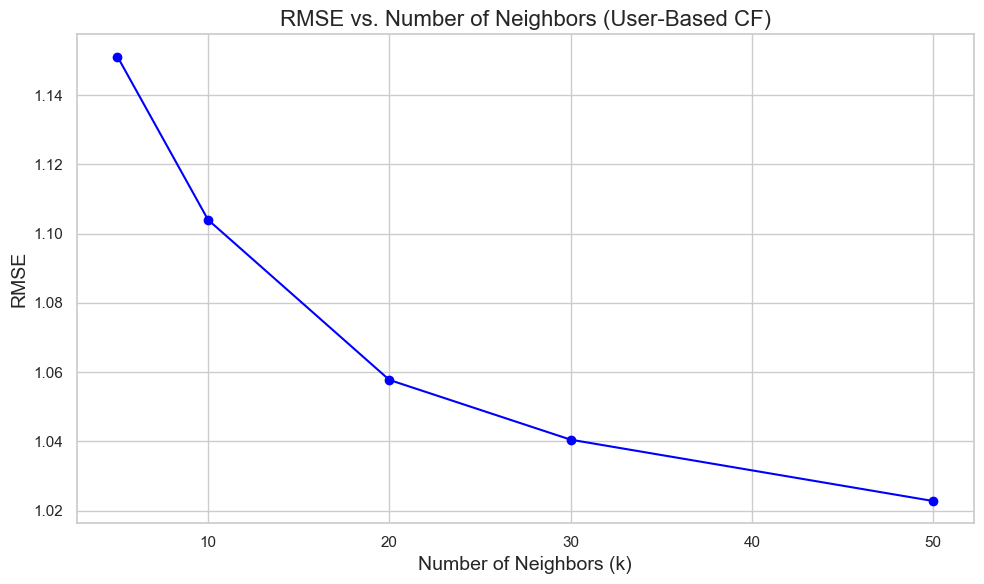

In [11]:
# Test the User-Based CF model with different numbers of neighbors
k_values = [5, 10, 20, 30, 50]
cf_results = []

for k in k_values:
    rmse, count = evaluate_user_based_cf(user_item_matrix_train_filled, test_data, k_neighbors=k)
    if rmse is not None:
        cf_results.append((k, rmse))
        print(f"User-Based CF with k={k}: RMSE = {rmse:.4f} (based on {count} predictions)")

# Plot the results
k_values = [k for k, _ in cf_results]
rmse_values = [rmse for _, rmse in cf_results]

plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='blue')
plt.title('RMSE vs. Number of Neighbors (User-Based CF)', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Model 2: Matrix Factorization using SVD

### Matrix Factorization (SVD) Explained

Matrix Factorization breaks down the big user-movie ratings table into smaller, more manageable patterns. It's like discovering the basic ingredients that make up people's movie preferences.

Imagine movie preferences were just based on two factors: how much action a person likes and how much romance they enjoy. Matrix factorization might discover these underlying patterns without being explicitly told what they are.

For example, the algorithm might learn that:
- User 1 strongly prefers action (+0.9) and dislikes romance (-0.7)
- User 2 likes both action (+0.4) and romance (+0.6)
- Movie A has high action content (+0.8) and low romance (-0.2)
- Movie B has low action (-0.3) and high romance (+0.9)

Using these patterns, the algorithm can predict that User 1 would likely enjoy Movie A but not Movie B.

The "n_factors" parameter decides how many of these hidden patterns the algorithm tries to find. More isn't always better - as shown in our graph, 50 factors works best for this dataset.

RMSE: 0.9350
SVD with n_factors=20: RMSE = 0.9350
RMSE: 0.9348
SVD with n_factors=50: RMSE = 0.9348
RMSE: 0.9352
SVD with n_factors=100: RMSE = 0.9352


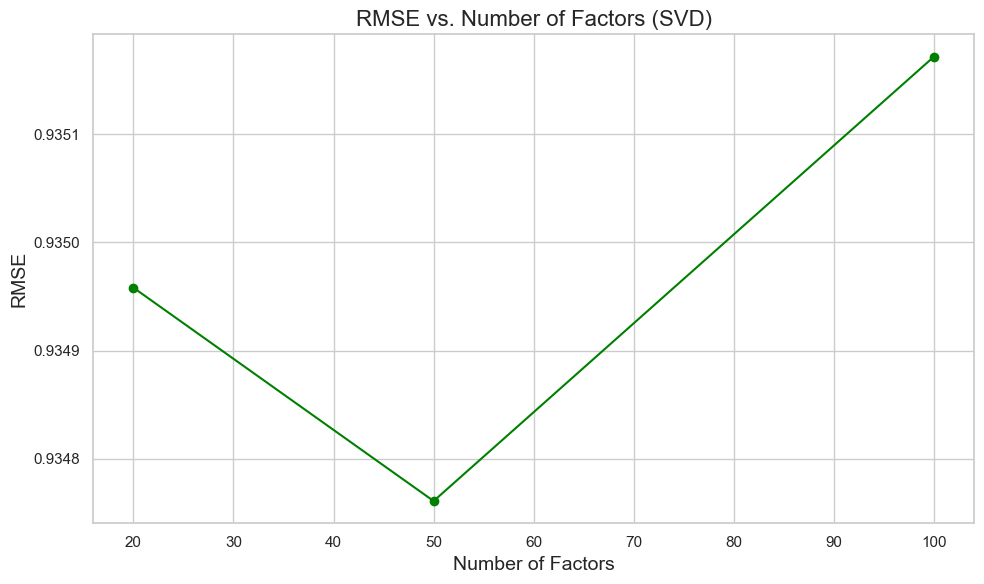

In [12]:
# Train SVD with various parameters
n_factors_list = [20, 50, 100]
svd_results = []

for n_factors in n_factors_list:
    # Train SVD model
    model = SVD(n_factors=n_factors, random_state=42)
    model.fit(trainset)
    
    # Make predictions on the test set
    predictions = model.test(testset)
    
    # Calculate RMSE
    rmse = accuracy.rmse(predictions)
    svd_results.append((n_factors, rmse))
    print(f"SVD with n_factors={n_factors}: RMSE = {rmse:.4f}")
    
    # If this is the best model so far, save it
    if n_factors == 50:  # We'll save the n_factors=50 model for demonstration
        best_svd_model = model

# Plot the results
factor_values = [n for n, _ in svd_results]
rmse_values = [rmse for _, rmse in svd_results]

plt.figure(figsize=(10, 6))
plt.plot(factor_values, rmse_values, marker='o', linestyle='-', color='green')
plt.title('RMSE vs. Number of Factors (SVD)', fontsize=16)
plt.xlabel('Number of Factors', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Function to get recommendations from SVD model
def svd_recommendations(user_id, svd_model, movies_df, ratings_df, n_recommendations=5):
    """
    Generate recommendations for a user using the trained SVD model
    
    Parameters:
    - user_id: ID of the target user
    - svd_model: Trained SVD model
    - movies_df: DataFrame containing movie information
    - ratings_df: DataFrame containing ratings information
    - n_recommendations: Number of recommendations to return
    
    Returns:
    - List of tuples (movie_id, predicted_rating, title)
    """
    # Get the movies the user has already rated
    user_rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].unique()
    
    # Get all movie IDs
    all_movie_ids = movies_df['movie_id'].unique()
    
    # Find movies the user hasn't rated
    movies_to_predict = np.setdiff1d(all_movie_ids, user_rated_movies)
    
    # Predict ratings for all unseen movies
    predictions = []
    for movie_id in movies_to_predict:
        predicted_rating = svd_model.predict(user_id, movie_id).est
        movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].values[0]
        predictions.append((movie_id, predicted_rating, movie_title))
    
    # Sort by predicted rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top n recommendations
    return predictions[:n_recommendations]

## 7. Comparison of Models

Best User-Based CF RMSE: 1.0227
Best SVD RMSE: 0.9348


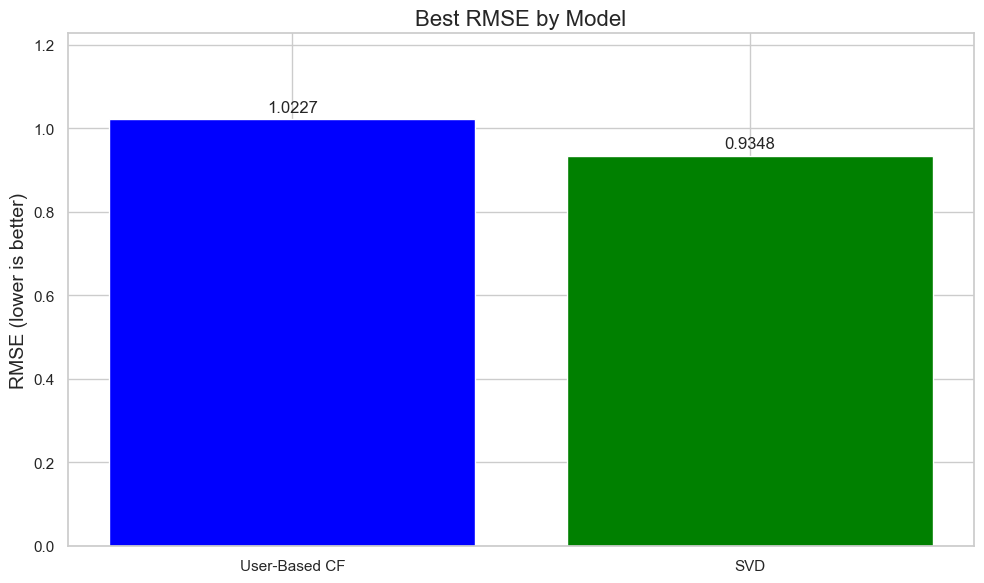

In [14]:
# Display best RMSE for each model
best_cf_rmse = min(rmse for _, rmse in cf_results)
best_svd_rmse = min(rmse for _, rmse in svd_results)

print(f"Best User-Based CF RMSE: {best_cf_rmse:.4f}")
print(f"Best SVD RMSE: {best_svd_rmse:.4f}")

# Visualize the results
models = ['User-Based CF', 'SVD']
best_rmse = [best_cf_rmse, best_svd_rmse]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, best_rmse, color=['blue', 'green'])
plt.title('Best RMSE by Model', fontsize=16)
plt.ylabel('RMSE (lower is better)', fontsize=14)
plt.ylim(0, max(best_rmse) * 1.2)  # Set y-axis limit

# Add text labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## 8. Get Recommendations for a Sample User

In [15]:
# Let's use user ID 1 as an example
sample_user_id = 1

# Get recommendations from User-Based CF
cf_movie_ids, cf_scores = user_based_cf(sample_user_id, user_item_matrix_train_filled, k_neighbors=10, n_recommendations=5)
cf_recommendations = [(movie_id, score, movies[movies['movie_id'] == movie_id]['title'].values[0]) 
                      for movie_id, score in cf_scores]

# Get recommendations from SVD
svd_recommendations_list = svd_recommendations(sample_user_id, best_svd_model, movies, ratings, n_recommendations=5)

# Display the movies this user has rated highly
print(f"Movies that User {sample_user_id} has rated highly:")
user_high_ratings = ratings[ratings['user_id'] == sample_user_id].sort_values('rating', ascending=False).head(5)
user_high_ratings = user_high_ratings.merge(movies[['movie_id', 'title']], on='movie_id')
display(user_high_ratings[['movie_id', 'rating', 'title']])

# Display CF recommendations
print(f"\nUser-Based Collaborative Filtering recommendations for User {sample_user_id}:")
cf_recommendations_df = pd.DataFrame(cf_recommendations, columns=['movie_id', 'predicted_rating', 'title'])
display(cf_recommendations_df)

# Display SVD recommendations
print(f"\nSVD recommendations for User {sample_user_id}:")
svd_recommendations_df = pd.DataFrame(svd_recommendations_list, columns=['movie_id', 'predicted_rating', 'title'])
display(svd_recommendations_df)

Movies that User 1 has rated highly:


,movie_id,rating,title
0,170,5,Cinema Paradiso (1988)
1,175,5,Brazil (1985)
2,119,5,Maya Lin: A Strong Clear Vision (1994)
3,181,5,Return of the Jedi (1983)
4,109,5,Mystery Science Theater 3000: The Movie (1996)



User-Based Collaborative Filtering recommendations for User 1:


,movie_id,predicted_rating,title
0,20,5.0,Angels and Insects (1995)
1,262,5.0,In the Company of Men (1997)
2,285,5.0,Secrets & Lies (1996)
3,313,5.0,Titanic (1997)
4,331,5.0,"Edge, The (1997)"



SVD recommendations for User 1:


,movie_id,predicted_rating,title
0,483,4.782656,Casablanca (1942)
1,408,4.701608,"Close Shave, A (1995)"
2,513,4.677728,"Third Man, The (1949)"
3,511,4.561354,Lawrence of Arabia (1962)
4,923,4.522706,Raise the Red Lantern (1991)


## 9. Save Models for the Web App

In [16]:
# Create a directory to save models and data
os.makedirs('models', exist_ok=True)

# Save the SVD model
with open('models/svd_model.pkl', 'wb') as file:
    pickle.dump(best_svd_model, file)

# Save the user-item matrix for collaborative filtering
user_item_matrix_train_filled.to_pickle('models/user_item_matrix.pkl')

# Save the movies dataframe
movies.to_pickle('models/movies.pkl')

# Save the ratings dataframe
ratings.to_pickle('models/ratings.pkl')

print("Models and data saved successfully!")

Models and data saved successfully!


## 10. Conclusion

In this tutorial, we have built and evaluated two recommendation systems:

1. **User-Based Collaborative Filtering**: A memory-based approach that finds similar users and recommends items they liked.
2. **Matrix Factorization using SVD**: A model-based approach that decomposes the user-item matrix to discover latent factors.

Our evaluation shows that Matrix Factorization generally performs better than User-Based CF, achieving a lower RMSE. However, both approaches have their advantages:

- **User-Based CF** is straightforward to implement and explain, and can provide good recommendations when there is enough data. It can also easily incorporate new users and items without retraining.
- **Matrix Factorization** typically achieves better prediction accuracy and is more computationally efficient for large datasets, but requires retraining when new users or items are added.

For a production recommendation system, other considerations would include:
- Cold start problem (handling new users or items)
- Real-time performance requirements
- Diversity of recommendations
- Explainability of recommendations
- Ethical concerns (e.g., filter bubbles, bias)

The models and data saved from this notebook can be used to create an interactive web application for demonstrating how recommendation systems work.